# ファインチューニングに使用したデータセット

参考としたコード
- Multilingual Sentiments Dataset
  - https://dev.classmethod.jp/articles/huggingface-jp-text-classification/
  - https://dev.classmethod.jp/articles/huggingface-usage-custom-model/
- 主観と客観の感情分析データセット
  - https://github.com/ghmagazine/llm-book/blob/main/chapter5/5-2-sentiment-analysis-finetuning-wrime.ipynb

In [2]:
import torch
# GPUが使用可能か判断
if torch.cuda.is_available():
    print('gpu is available')
else:
    raise Exception('gpu is NOT available')

gpu is available


In [3]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## multilingual-sentiments

In [4]:
from pprint import pprint
from datasets import load_dataset

# Hugging Face Hub上ののリポジトリからデータを読み込む
train_multi_dataset = load_dataset("tyqiangz/multilingual-sentiments", "japanese", split="train")
valid_multi_dataset = load_dataset("tyqiangz/multilingual-sentiments", "japanese", split="validation")
test_multi_dataset = load_dataset("tyqiangz/multilingual-sentiments", "japanese", split="test")
# pprintで見やすく表示する
pprint(train_multi_dataset)
pprint(valid_multi_dataset)
pprint(test_multi_dataset)

Dataset({
    features: ['text', 'source', 'label'],
    num_rows: 120000
})
Dataset({
    features: ['text', 'source', 'label'],
    num_rows: 3000
})
Dataset({
    features: ['text', 'source', 'label'],
    num_rows: 3000
})


In [5]:
multi_dataset = load_dataset('tyqiangz/multilingual-sentiments', 'japanese')
multi_dataset.set_format(type='pandas')
df = multi_dataset['train'][:]

In [6]:
multi_dataset['train'].features

{'text': Value(dtype='string', id=None),
 'source': Value(dtype='string', id=None),
 'label': ClassLabel(names=['positive', 'neutral', 'negative'], id=None)}

In [7]:
df0 = df[df['label']==0][:2]
df0['label_name'] = 'positive'
df1 = df[df['label']==1][:2]
df1['label_name'] = 'neutral'
df2 = df[df['label']==2][:2]
df2['label_name'] = 'negative'
df_merge = pd.concat([df2, df1, df0])
df_merge

,text,source,label,label_name
0,普段使いとバイクに乗るときのブーツ兼用として購入しました。見た目や履き心地は良いです。 しか...,amazon_reviews_multi,2,negative
1,十分な在庫を用意できない販売元も悪いですが、Amazonやら楽⚪︎が転売を認めちゃってるのが...,amazon_reviews_multi,2,negative
40000,初めてのグローブを買いました。使った感じは他のレビューの通り指先あたりの縫製が少し雑。手のひ...,amazon_reviews_multi,1,neutral
40001,まだ使用していませんが、使い道が広いと思います。同じものが100均で販売されていたのが残念。,amazon_reviews_multi,1,neutral
80000,名探偵コナンが好きだから すごく良かったです。,amazon_reviews_multi,0,positive
80001,以前水泳をやっていた頃にこういった商品を使っていましたが、今はお風呂上がりに使ってます。肌に...,amazon_reviews_multi,0,positive


In [8]:
from IPython.display import HTML
# Stylerクラスのインスタンスを作成
styled = df_merge.style.set_properties(**{'text-align': 'left'})
 
# HTML形式に変換して表示
HTML(styled.render())

/tmp/ipykernel_152525/3144582184.py:6: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  HTML(styled.render())


,text,source,label,label_name
0,普段使いとバイクに乗るときのブーツ兼用として購入しました。見た目や履き心地は良いです。 しかし、２ヶ月履いたらゴム底が削れて無くなりました。また、バイクのシフトペダルとの摩擦で表皮が剥がれ、本革でないことが露呈しました。ちなみに防水とも書いていますが、雨の日は内部に水が染みます。 安くて見た目も良く、履きやすかったのですが、耐久性のなさ、本革でも防水でも無かったことが残念です。結局、本革の防水ブーツを買い直しました。,amazon_reviews_multi,2,negative
1,十分な在庫を用意できない販売元も悪いですが、Amazonやら楽⚪︎が転売を認めちゃってるのが結果的に転売の後押しになっちゃってるんだよなぁ… Amazonもここぞとばかりに抱き合わせ販売しまくるし… それを恥ずかしいと思えなくなったら動物と同じですよ、最大手さん。,amazon_reviews_multi,2,negative
40000,初めてのグローブを買いました。使った感じは他のレビューの通り指先あたりの縫製が少し雑。手のひら側のパットは少し多目。,amazon_reviews_multi,1,neutral
40001,まだ使用していませんが、使い道が広いと思います。同じものが100均で販売されていたのが残念。,amazon_reviews_multi,1,neutral
80000,名探偵コナンが好きだから すごく良かったです。,amazon_reviews_multi,0,positive
80001,以前水泳をやっていた頃にこういった商品を使っていましたが、今はお風呂上がりに使ってます。肌に乗せて水滴をポンポンっと取る感じです。 使用したら軽く洗って浴室内の物干しにかけて置いてます。一晩でカラカラになりますが、今のところ割れたりはしていません。 柔らかく、肌ざわりも良く、凹凸？のあるところも気に入っています。 我が家はタオルの置いてある脱衣所が寒いので、浴室内にてこれで拭いて出られるので重宝しています。バスタオルも使わなくて済み、洗濯も楽になりました。買って良かったなと思っています。,amazon_reviews_multi,0,positive


In [9]:
from transformers import AutoTokenizer
# トークナイザのロード
model_name = "cl-tohoku/bert-base-japanese-whole-word-masking"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [10]:
# 大規模言語モデル入門に記載されているコードで視覚化して検証
from collections import Counter
from tqdm import tqdm

plt.rcParams["font.size"] = 18  # 文字サイズを大きくする

def text_length(dataset, text_col):
    # データセット中のテキストのトークン数の分布を取得
    length_counter = Counter()
    for data in tqdm(dataset):
        length = len(tokenizer.tokenize(data[text_col]))
        length_counter[length] += 1
    return length_counter

def dataset_labels(dataset, label_col):
    # データセット中のラベルの数を数える
    label_counter = Counter()
    for data in dataset:
        label_id = data[label_col]
        label_name = dataset.features[label_col].names[label_id]
        label_counter[label_name] += 1
    return label_counter

def visualize_labels(label_counter):
    # label_counterをグラフ表示
    plt.bar(label_counter.keys(), label_counter.values())
    plt.xlabel('ラベル')
    plt.ylabel('事例数')
    plt.show()

def visualize_text_length(length_counter):
    # length_counterの値から棒グラフを描画する
    plt.bar(length_counter.keys(), length_counter.values(), width=1.0)
    plt.xlabel("トークン数")
    plt.ylabel("事例数")
    plt.show()

In [11]:
# トークン数の分布
train_multi_dataset_length = text_length(train_multi_dataset, 'text')
# ラベルの分布
train_multi_dataset_label = dataset_labels(train_multi_dataset, 'label')

100%|██████████| 120000/120000 [00:15<00:00, 7861.67it/s]


In [12]:
def add_value_label(x_list, y_list):
    for i in range(len(x_list)):
        plt.text(i, list(y_list)[i] / 2, list(y_list)[i], ha="center", c='white')

def visualize_labels_text(length_counter, label_counter):
    fig = plt.figure(figsize=(15, 5))
    fig.subplots_adjust()
    plt.subplot(1, 2, 1)
    plt.bar(length_counter.keys(), length_counter.values(), width=1.0)
    plt.xlabel("トークン数")
    plt.ylabel("事例数")
    plt.subplot(1, 2, 2)
    plt.bar(label_counter.keys(), label_counter.values())
    add_value_label([0, 1, 2], label_counter.values())
    plt.xlabel('ラベル')
    plt.tight_layout()
    plt.show()

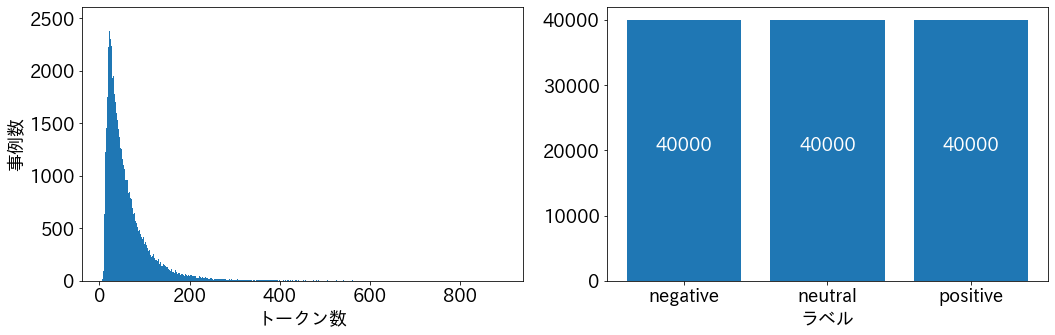

In [13]:
visualize_labels_text(train_multi_dataset_length, train_multi_dataset_label)

In [14]:
print('max:',max(train_multi_dataset_length.keys()))
PERCENT=75
print(f'{PERCENT}%:',np.percentile([k for k in train_multi_dataset_length.keys()], PERCENT))
PERCENT=80
print(f'{PERCENT}%:',np.percentile([k for k in train_multi_dataset_length.keys()], PERCENT))

max: 895
75%: 476.0
80%: 518.8


## shunk031/wrime

### wrime ver1

In [15]:
wrime_dataset1 = load_dataset("shunk031/wrime", name="ver1")
wrime_dataset1

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

/root/.cache/huggingface/modules/datasets_modules/datasets/shunk031--wrime/4b2571d8c51503a1134ff7edb2293a2ccb16632689d2f064b8afda72ec9e01ce/wrime.py:80: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace(". ", "_")


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'user_id', 'datetime', 'writer', 'reader1', 'reader2', 'reader3', 'avg_readers'],
        num_rows: 40000
    })
    validation: Dataset({
        features: ['sentence', 'user_id', 'datetime', 'writer', 'reader1', 'reader2', 'reader3', 'avg_readers'],
        num_rows: 1200
    })
    test: Dataset({
        features: ['sentence', 'user_id', 'datetime', 'writer', 'reader1', 'reader2', 'reader3', 'avg_readers'],
        num_rows: 2000
    })
})

In [16]:
pprint(wrime_dataset1['train'][0])

{'avg_readers': {'anger': 0,
                 'anticipation': 0,
                 'disgust': 0,
                 'fear': 0,
                 'joy': 0,
                 'sadness': 2,
                 'surprise': 0,
                 'trust': 0},
 'datetime': '2012/07/31 23:48',
 'reader1': {'anger': 0,
             'anticipation': 0,
             'disgust': 0,
             'fear': 0,
             'joy': 0,
             'sadness': 2,
             'surprise': 0,
             'trust': 0},
 'reader2': {'anger': 0,
             'anticipation': 0,
             'disgust': 0,
             'fear': 0,
             'joy': 0,
             'sadness': 2,
             'surprise': 1,
             'trust': 0},
 'reader3': {'anger': 0,
             'anticipation': 0,
             'disgust': 1,
             'fear': 1,
             'joy': 0,
             'sadness': 2,
             'surprise': 0,
             'trust': 0},
 'sentence': 'ぼけっとしてたらこんな時間｡チャリあるから食べにでたいのに…',
 'user_id': '1',
 'writer': {'anger': 1,

In [17]:
wrime_dataset1.set_format('pandas')
df1 = wrime_dataset1['train'][:]
df1.head()

,sentence,user_id,datetime,writer,reader1,reader2,reader3,avg_readers
0,ぼけっとしてたらこんな時間｡チャリあるから食べにでたいのに…,1,2012/07/31 23:48,"{'joy': 0, 'sadness': 1, 'anticipation': 2, 's...","{'joy': 0, 'sadness': 2, 'anticipation': 0, 's...","{'joy': 0, 'sadness': 2, 'anticipation': 0, 's...","{'joy': 0, 'sadness': 2, 'anticipation': 0, 's...","{'joy': 0, 'sadness': 2, 'anticipation': 0, 's..."
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな? と立ち止まる帰り道｡チャリなし生活も...,1,2012/08/02 23:09,"{'joy': 3, 'sadness': 0, 'anticipation': 3, 's...","{'joy': 0, 'sadness': 0, 'anticipation': 0, 's...","{'joy': 1, 'sadness': 0, 'anticipation': 0, 's...","{'joy': 2, 'sadness': 0, 'anticipation': 0, 's...","{'joy': 1, 'sadness': 0, 'anticipation': 0, 's..."
2,早寝するつもりが飲み物がなくなりコンビニへ｡ん､今日、風が涼しいな。,1,2012/08/05 00:50,"{'joy': 1, 'sadness': 1, 'anticipation': 1, 's...","{'joy': 0, 'sadness': 0, 'anticipation': 0, 's...","{'joy': 0, 'sadness': 0, 'anticipation': 0, 's...","{'joy': 0, 'sadness': 0, 'anticipation': 0, 's...","{'joy': 0, 'sadness': 0, 'anticipation': 0, 's..."
3,眠い、眠れない。,1,2012/08/08 01:36,"{'joy': 0, 'sadness': 2, 'anticipation': 1, 's...","{'joy': 0, 'sadness': 0, 'anticipation': 0, 's...","{'joy': 0, 'sadness': 1, 'anticipation': 0, 's...","{'joy': 0, 'sadness': 2, 'anticipation': 0, 's...","{'joy': 0, 'sadness': 1, 'anticipation': 0, 's..."
4,ただいま? って新体操してるやん!外食する気満々で家に何もないのに!テレビから離れられない…!,1,2012/08/09 22:24,"{'joy': 2, 'sadness': 1, 'anticipation': 3, 's...","{'joy': 0, 'sadness': 0, 'anticipation': 0, 's...","{'joy': 1, 'sadness': 0, 'anticipation': 0, 's...","{'joy': 2, 'sadness': 0, 'anticipation': 0, 's...","{'joy': 1, 'sadness': 0, 'anticipation': 0, 's..."


In [18]:
df1[df1['sentence'].str.contains('車のタイヤがパンクしてた')]

,sentence,user_id,datetime,writer,reader1,reader2,reader3,avg_readers
3661,車のタイヤがパンクしてた。。いたずらの可能性が高いんだって。。,6,2017/06/24 17:43,"{'joy': 0, 'sadness': 3, 'anticipation': 0, 's...","{'joy': 0, 'sadness': 3, 'anticipation': 0, 's...","{'joy': 0, 'sadness': 2, 'anticipation': 0, 's...","{'joy': 0, 'sadness': 2, 'anticipation': 0, 's...","{'joy': 0, 'sadness': 2, 'anticipation': 0, 's..."


In [19]:
wrime_dataset1.reset_format()
pprint(wrime_dataset1['train'][3661])

{'avg_readers': {'anger': 0,
                 'anticipation': 0,
                 'disgust': 1,
                 'fear': 1,
                 'joy': 0,
                 'sadness': 2,
                 'surprise': 2,
                 'trust': 0},
 'datetime': '2017/06/24 17:43',
 'reader1': {'anger': 1,
             'anticipation': 0,
             'disgust': 1,
             'fear': 2,
             'joy': 0,
             'sadness': 3,
             'surprise': 3,
             'trust': 0},
 'reader2': {'anger': 0,
             'anticipation': 0,
             'disgust': 0,
             'fear': 0,
             'joy': 0,
             'sadness': 2,
             'surprise': 2,
             'trust': 0},
 'reader3': {'anger': 0,
             'anticipation': 0,
             'disgust': 1,
             'fear': 1,
             'joy': 0,
             'sadness': 2,
             'surprise': 2,
             'trust': 0},
 'sentence': '車のタイヤがパンクしてた。。いたずらの可能性が高いんだって。。',
 'user_id': '6',
 'writer': {'anger': 3

### wrime ver2

In [20]:
from pprint import pprint
from datasets import load_dataset

# Hugging Face Hub上ののリポジトリからデータを読み込む
wrime_dataset2 = load_dataset("shunk031/wrime", name="ver2")
# pprintで見やすく表示する
pprint(wrime_dataset2)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

/root/.cache/huggingface/modules/datasets_modules/datasets/shunk031--wrime/4b2571d8c51503a1134ff7edb2293a2ccb16632689d2f064b8afda72ec9e01ce/wrime.py:80: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace(". ", "_")


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

{'test': Dataset({
    features: ['sentence', 'user_id', 'datetime', 'writer', 'reader1', 'reader2', 'reader3', 'avg_readers'],
    num_rows: 2500
}),
 'train': Dataset({
    features: ['sentence', 'user_id', 'datetime', 'writer', 'reader1', 'reader2', 'reader3', 'avg_readers'],
    num_rows: 30000
}),
 'validation': Dataset({
    features: ['sentence', 'user_id', 'datetime', 'writer', 'reader1', 'reader2', 'reader3', 'avg_readers'],
    num_rows: 2500
})}


In [21]:
pprint(wrime_dataset2['train'][0])

{'avg_readers': {'anger': 0,
                 'anticipation': 0,
                 'disgust': 0,
                 'fear': 0,
                 'joy': 0,
                 'sadness': 2,
                 'sentiment': -1,
                 'surprise': 0,
                 'trust': 0},
 'datetime': '2012/7/31 23:48',
 'reader1': {'anger': 0,
             'anticipation': 0,
             'disgust': 0,
             'fear': 0,
             'joy': 0,
             'sadness': 2,
             'sentiment': -2,
             'surprise': 0,
             'trust': 0},
 'reader2': {'anger': 0,
             'anticipation': 0,
             'disgust': 1,
             'fear': 1,
             'joy': 0,
             'sadness': 2,
             'sentiment': -1,
             'surprise': 0,
             'trust': 0},
 'reader3': {'anger': 0,
             'anticipation': 0,
             'disgust': 0,
             'fear': 0,
             'joy': 0,
             'sadness': 2,
             'sentiment': -1,
             'surp

In [22]:
wrime_dataset2.set_format('pandas')
df2 = wrime_dataset2['train'][:]
df2.head()

,sentence,user_id,datetime,writer,reader1,reader2,reader3,avg_readers
0,ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…,1,2012/7/31 23:48,"{'joy': 0, 'sadness': 1, 'anticipation': 2, 's...","{'joy': 0, 'sadness': 2, 'anticipation': 0, 's...","{'joy': 0, 'sadness': 2, 'anticipation': 0, 's...","{'joy': 0, 'sadness': 2, 'anticipation': 0, 's...","{'joy': 0, 'sadness': 2, 'anticipation': 0, 's..."
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな〜 と立ち止まる帰り道。チャリなし生活も...,1,2012/8/2 23:09,"{'joy': 3, 'sadness': 0, 'anticipation': 3, 's...","{'joy': 0, 'sadness': 0, 'anticipation': 0, 's...","{'joy': 2, 'sadness': 0, 'anticipation': 0, 's...","{'joy': 1, 'sadness': 0, 'anticipation': 0, 's...","{'joy': 1, 'sadness': 0, 'anticipation': 0, 's..."
2,早寝するつもりが飲み物がなくなりコンビニへ。ん、今日、風が涼しいな。,1,2012/8/5 0:50,"{'joy': 1, 'sadness': 1, 'anticipation': 1, 's...","{'joy': 0, 'sadness': 0, 'anticipation': 0, 's...","{'joy': 0, 'sadness': 0, 'anticipation': 0, 's...","{'joy': 0, 'sadness': 0, 'anticipation': 0, 's...","{'joy': 0, 'sadness': 0, 'anticipation': 0, 's..."
3,眠い、眠れない。,1,2012/8/8 1:36,"{'joy': 0, 'sadness': 2, 'anticipation': 1, 's...","{'joy': 0, 'sadness': 0, 'anticipation': 0, 's...","{'joy': 0, 'sadness': 2, 'anticipation': 0, 's...","{'joy': 0, 'sadness': 1, 'anticipation': 0, 's...","{'joy': 0, 'sadness': 1, 'anticipation': 0, 's..."
4,ただいま〜 って新体操してるやん!外食する気満々で家に何もないのに!テレビから離れられない…!,1,2012/8/9 22:24,"{'joy': 2, 'sadness': 1, 'anticipation': 3, 's...","{'joy': 0, 'sadness': 0, 'anticipation': 0, 's...","{'joy': 2, 'sadness': 0, 'anticipation': 0, 's...","{'joy': 1, 'sadness': 0, 'anticipation': 0, 's...","{'joy': 1, 'sadness': 0, 'anticipation': 0, 's..."


In [23]:
df2[df2['sentence'].str.contains('車のタイヤがパンクしてた')]

,sentence,user_id,datetime,writer,reader1,reader2,reader3,avg_readers
2661,車のタイヤがパンクしてた。。いたずらの可能性が高いんだって。。,6,2017/6/24 17:43,"{'joy': 0, 'sadness': 3, 'anticipation': 0, 's...","{'joy': 0, 'sadness': 3, 'anticipation': 0, 's...","{'joy': 0, 'sadness': 2, 'anticipation': 0, 's...","{'joy': 0, 'sadness': 2, 'anticipation': 0, 's...","{'joy': 0, 'sadness': 2, 'anticipation': 0, 's..."


In [24]:
wrime_dataset2.reset_format()
pprint(wrime_dataset2['train'][2661])

{'avg_readers': {'anger': 0,
                 'anticipation': 0,
                 'disgust': 1,
                 'fear': 1,
                 'joy': 0,
                 'sadness': 2,
                 'sentiment': -1,
                 'surprise': 2,
                 'trust': 0},
 'datetime': '2017/6/24 17:43',
 'reader1': {'anger': 1,
             'anticipation': 0,
             'disgust': 1,
             'fear': 2,
             'joy': 0,
             'sadness': 3,
             'sentiment': -1,
             'surprise': 3,
             'trust': 0},
 'reader2': {'anger': 0,
             'anticipation': 0,
             'disgust': 1,
             'fear': 1,
             'joy': 0,
             'sadness': 2,
             'sentiment': -2,
             'surprise': 2,
             'trust': 0},
 'reader3': {'anger': 0,
             'anticipation': 0,
             'disgust': 0,
             'fear': 0,
             'joy': 0,
             'sadness': 2,
             'sentiment': -1,
             'surp

In [25]:
# トークン数の分布
train_wrime_dataset_length = text_length(wrime_dataset2['train'], 'sentence')

100%|██████████| 30000/30000 [00:03<00:00, 8262.38it/s]


Text(0, 0.5, '事例数')

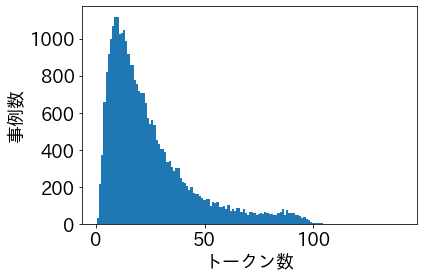

In [26]:
plt.bar(train_wrime_dataset_length.keys(), train_wrime_dataset_length.values(), width=1.0)
plt.xlabel("トークン数")
plt.ylabel("事例数")

### wrime-sentiment

In [27]:
# Hugging Face Hub上ののリポジトリからデータを読み込む
wrime_sentiment = load_dataset("llm-book/wrime-sentiment", remove_neutral=False)
# pprintで見やすく表示する
pprint(wrime_sentiment)

{'test': Dataset({
    features: ['sentence', 'label', 'user_id', 'datetime'],
    num_rows: 2500
}),
 'train': Dataset({
    features: ['sentence', 'label', 'user_id', 'datetime'],
    num_rows: 30000
}),
 'validation': Dataset({
    features: ['sentence', 'label', 'user_id', 'datetime'],
    num_rows: 2500
})}


In [28]:
pprint(wrime_sentiment['train'][0])

{'datetime': '2012/7/31 23:48',
 'label': 1,
 'sentence': 'ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…',
 'user_id': 1}


In [29]:
wrime_sentiment.set_format('pandas')
df3 = wrime_sentiment['train'][:]
df3.head()

,sentence,label,user_id,datetime
0,ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…,1,1,2012/7/31 23:48
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな〜 と立ち止まる帰り道。チャリなし生活も...,0,1,2012/8/2 23:09
2,早寝するつもりが飲み物がなくなりコンビニへ。ん、今日、風が涼しいな。,2,1,2012/8/5 0:50
3,眠い、眠れない。,1,1,2012/8/8 1:36
4,ただいま〜 って新体操してるやん!外食する気満々で家に何もないのに!テレビから離れられない…!,2,1,2012/8/9 22:24


In [30]:
df2.loc[1,'avg_readers']

{'joy': 1,
 'sadness': 0,
 'anticipation': 0,
 'surprise': 2,
 'anger': 0,
 'fear': 0,
 'disgust': 0,
 'trust': 0,
 'sentiment': 1}

In [31]:
wrime_sentiment['train'].features

{'sentence': Value(dtype='string', id=None),
 'label': ClassLabel(names=['positive', 'negative', 'neutral'], id=None),
 'user_id': Value(dtype='int64', id=None),
 'datetime': Value(dtype='string', id=None)}

In [32]:
df3[df3['sentence'].str.contains('車のタイヤがパンクしてた')]

,sentence,label,user_id,datetime
2661,車のタイヤがパンクしてた。。いたずらの可能性が高いんだって。。,1,6,2017/6/24 17:43


In [33]:
wrime_sentiment.reset_format()
wrime_sentiment['train'][2661]

{'sentence': '車のタイヤがパンクしてた。。いたずらの可能性が高いんだって。。',
 'label': 1,
 'user_id': 6,
 'datetime': '2017/6/24 17:43'}

In [34]:
wrime_sentiment['train'].features

{'sentence': Value(dtype='string', id=None),
 'label': ClassLabel(names=['positive', 'negative', 'neutral'], id=None),
 'user_id': Value(dtype='int64', id=None),
 'datetime': Value(dtype='string', id=None)}

In [35]:
# トークン数の分布
train_wrime_sentiment_length = text_length(wrime_sentiment['train'], 'sentence')
# ラベルの分布
train_wrime_sentiment_label = dataset_labels(wrime_sentiment['train'], 'label')

100%|██████████| 30000/30000 [00:02<00:00, 13678.57it/s]


In [36]:
train_wrime_sentiment_label

Counter({'negative': 10653, 'positive': 9496, 'neutral': 9851})

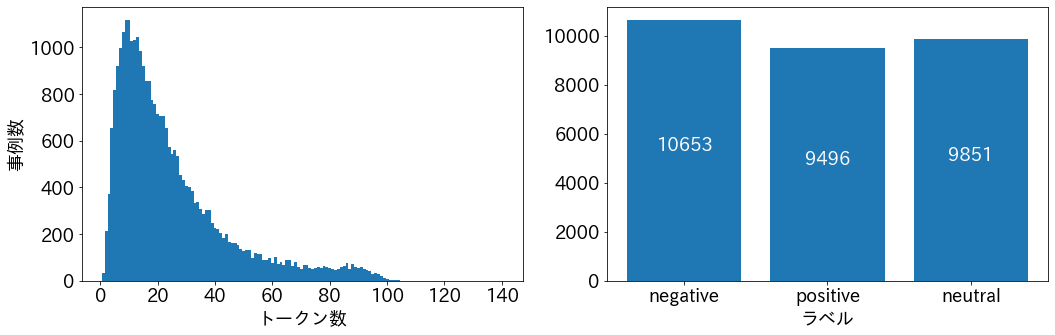

In [37]:
visualize_labels_text(train_wrime_sentiment_length, train_wrime_sentiment_label)

In [38]:
print('max:',max(train_wrime_sentiment_length.keys()))
PERCENT=75
print(f'{PERCENT}%:',np.percentile([k for k in train_wrime_sentiment_length.keys()], PERCENT))
PERCENT=80
print(f'{PERCENT}%:',np.percentile([k for k in train_wrime_sentiment_length.keys()], PERCENT))
PERCENT=90
print(f'{PERCENT}%:',np.percentile([k for k in train_wrime_sentiment_length.keys()], PERCENT))

max: 140
75%: 82.75
80%: 88.2
90%: 99.10000000000001
